## 0. 导入模块和数据

In [1]:
import pandas as pd
import numpy as np
import os

#### 数据准备：将文件名filename和状态status放在一起

In [2]:
df_imgId = pd.read_excel('2021MCM_ProblemC_ Images_by_GlobalID.xlsx')
df_dataset = pd.read_excel('2021MCMProblemC_DataSet.xlsx')
df_count = np.sum(df_imgId['GlobalID'].isin(df_dataset['GlobalID']))
print("df_imgId与df_dataset基于GlobalID相关联的数据量 : ", df_count)
data_name_label = pd.merge(df_dataset, df_imgId, on='GlobalID', how='inner')
data_name_label = data_name_label[['FileName','Lab Status']]
data_name_label.to_csv('data_name_label.csv',index=None)

df_imgId与df_dataset基于GlobalID相关联的数据量 :  3305


In [3]:
print(len(data_name_label))

3305


### 预先准备的函数

In [4]:
##### 删除文件夹下所有文件
def del_file(filepath):
    del_list = os.listdir(filepath)
    for f in del_list:
        file_path = os.path.join(filepath, f)
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
##### 创建文件夹
def mkdir(path):
    folder = os.path.exists(path)
    if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
        os.makedirs(path)            #makedirs 创建文件时如果路径不存在会创建这个路径
        #print ("---  OK  ---")
 
    else:
        print ("---  There is this folder!  ---")
#file = r"D:/filecreate_test"
#mkdir(file)   

## 1. 预处理——数据集规范化存储命名

In [94]:
import d2l.torch as d2l
import shutil
#创建文件夹
file_train= r'D:/data_final assignment/train/'
file_test= r'D:/data_final assignment/test/'
mkdir(file_train)
mkdir(file_test) 
path_source = r'D:/data_new/'
path_datatrain = r'D:/data_final assignment/train/'
path_datatest = r'D:/data_final assignment/test/'
del_file(path_datatrain)
del_file(path_datatest)

filename_list=list(data_name_label['FileName'])
label_list=list(data_name_label['Lab Status'])
data_name_label_new=data_name_label
con = 0
fileName_list_new=[]
label_list_new=[]
for i in range(len(data_name_label)):
    fileName=filename_list[i]
    label=label_list[i]
    file_src = os.path.join(path_source, fileName)
    if os.path.exists(file_src):
        if label == 'Positive ID' or label == 'Negative ID':
            fileName_list_new.append(fileName)
            label_list_new.append(label)
            ### 放入训练集中
            shutil.copyfile(file_src,os.path.join(path_datatrain, fileName))
            os.rename(os.path.join(path_datatrain, fileName), os.path.join(path_datatrain, f'{label}_' + fileName))
        else:
            ### 放入测试集中
            shutil.copyfile(file_src,os.path.join(path_datatest, fileName))
            data_name_label_new=data_name_label_new.drop([i])
    else:
        continue
    con += 1
    print(f'已完成{con}条数据的读入！' ,end="\r")

## 新建一个csv文件 注意：这里使用w 意为新建文件（覆盖）!
with open('Name_Label_final.csv', 'w+') as f:
    f.write(f'FileName,Lab Status')
for index in range(len(fileName_list_new)):
    with open('Name_Label_final.csv', 'a+') as f:
        f.write(f'\n{fileName_list_new[index]},{label_list_new[index]}')
    f.close()

In [95]:
print(len(data_name_label_new))

3296


## 3. 数据集正例数据增强

In [96]:
from imgaug import augmenters as iaa
import sys
import cv2
import shutil
import warnings
## 警告退散！
warnings.filterwarnings('ignore')
print('cv2 version:', cv2.__version__)
## ??cv2.imread()

cv2 version: 4.5.2


In [97]:
# 数据增强
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
# 使用lambda调用sometimes函数
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# 定义一组变换方法.
seq = iaa.Sequential([

    # 选择0到5种方法做变换
    iaa.SomeOf((0, 5),
               [
                   iaa.Fliplr(0.5),  # 对50%的图片进行水平镜像翻转
                   iaa.Flipud(0.5),  # 对50%的图片进行垂直镜像翻转

                   # Convert some images into their superpixel representation,
                   # sample between 20 and 200 superpixels per image, but do
                   # not replace all superpixels with their average, only
                   # some of them (p_replace).
                   sometimes(
                       iaa.Superpixels(
                           p_replace=(0, 1.0),
                           n_segments=(20, 200)
                       )
                   ),

                   # Blur each image with varying strength using
                   # gaussian blur (sigma between 0 and 3.0),
                   # average/uniform blur (kernel size between 2x2 and 7x7)
                   # median blur (kernel size between 3x3 and 11x11).
                   iaa.OneOf([
                       iaa.GaussianBlur((0, 3.0)),
                       iaa.AverageBlur(k=(2, 7)),
                       iaa.MedianBlur(k=(3, 11)),
                   ]),

                   # Sharpen each image, overlay the result with the original
                   # image using an alpha between 0 (no sharpening) and 1
                   # (full sharpening effect).
                   iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                   # Same as sharpen, but for an embossing effect.
                   iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),

                   # Add gaussian noise to some images.
                   # In 50% of these cases, the noise is randomly sampled per
                   # channel and pixel.
                   # In the other 50% of all cases it is sampled once per
                   # pixel (i.e. brightness change).
                   iaa.AdditiveGaussianNoise(
                       loc=0, scale=(0.0, 0.05 * 255)
                   ),

                   # Invert each image's chanell with 5% probability.
                   # This sets each pixel value v to 255-v.
                   iaa.Invert(0.05, per_channel=True),  # invert color channels

                   # Add a value of -10 to 10 to each pixel.
                   iaa.Add((-10, 10), per_channel=0.5),

                   # Add random values between -40 and 40 to images, with each value being sampled per pixel:
                   iaa.AddElementwise((-40, 40)),

                   # Change brightness of images (50-150% of original value).
                   iaa.Multiply((0.5, 1.5)),

                   # Multiply each pixel with a random value between 0.5 and 1.5.
                   iaa.MultiplyElementwise((0.5, 1.5)),

                   # Improve or worsen the contrast of images.
                   iaa.ContrastNormalization((0.5, 2.0)),

               ],
               # do all of the above augmentations in random order
               random_order=True
               )

], random_order=True)  # apply augmenters in random order

In [98]:
# 图片文件相关路径
path_augment = path_datatrain
## 找到该目录下的所有文件
filelist = os.listdir(path_datatrain)

imglist = []
positive_list = []
# 遍历要增强的文件夹，把所有的图片保存在imglist中
for item in filelist:
    if 'Positive' in item:
        img = cv2.imread(os.path.join(path_datatrain, item))
        positive_list.append(item)
        imglist.append(img)
print('已经将所有需要强化的数据图片（Positive ID）导入进数据列表imglist中！')
print('数据图片列表：',positive_list,'\n','总计',len(positive_list),'张图片~')

已经将所有需要强化的数据图片（Positive ID）导入进数据列表imglist中！
数据图片列表： ['Positive ID_ATT1_DSCN9647.jpg', 'Positive ID_ATT2302_image0-2.jpg', 'Positive ID_ATT256_47C3AA1B-C9D4-46FA-9D30-39655ACE1604.jpg', 'Positive ID_ATT2_HoireRDBeekeeperReport.jpg', 'Positive ID_ATT369_Langley 16 May.jpg', 'Positive ID_ATT422_image001.jpg', 'Positive ID_ATT472_9246EB0A-0DDF-420C-979D-C631943D3BFD.jpg', 'Positive ID_ATT5_20190918_230100.jpg', 'Positive ID_ATT6_20190918_235343.jpg'] 
 总计 9 张图片~


In [99]:
# 这一步用于检查imread()命令是否成立，这里务必注意使用非中文路径的文件夹！
# imglist

In [100]:
# 对文件夹中的图片进行增强操作，循环augment_times次
# 图片增强！
augment_times=30
filenames = []
for count in range(augment_times):
    # 进行图片增强 每次增强实现一条imglist的更新
    images_aug = seq.augment_images(imglist)
    for index in range(len(images_aug)):
        # 修改文件名
        filename = f'{positive_list[index][:-4]}_augment_{count}.jpg'
        # 保存图片
        cv2.imwrite(path_augment+ filename, images_aug[index])
        filenames.append(filename)
    print(f'已进行{count+1}次图片增强 / 共计{augment_times}次',end="\r")

In [101]:
filenames[0].split('.', 1)

['Positive ID_ATT1_DSCN9647_augment_0', 'jpg']

In [102]:
## 更新初始表格 现在positive和negative的条目数量可以尽量保持一致
## 更新上述csv文件 注意：这里使用a+ 意为续写文件（覆盖）!
for filename in filenames:
    label, name = filename.split('_', 1)
    with open('Name_Label_final.csv', 'a+') as f:
        f.write(f'\n{name},{label}')

**至此，数据集所有准备工作已经完毕！**

## 4. 卷积神经网络

In [103]:
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
import os

In [104]:
df= pd.read_csv('Name_Label_final.csv')
for i in range(len(df)):
    df.iloc[i][0]=df.iloc[i][1]+'_'+df.iloc[i][0]
df.to_csv('Name_Label_final_new.csv',index=None)

In [105]:
labels = d2l.read_csv_labels('Name_Label_final_new.csv')
#labels.items()
#{k[:-4]:v for k,v in labels.items()}

In [106]:
# 定义初始参数
valid_ratio = 0.1
batch_size = 32
## batch_size：每批数据量的大小。DL通常用SGD的优化算法进行训练，
## 也就是一次（1 个iteration）一起训练batchsize个样本，计算它们的平均损失函数值，来更新参数。
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir=r'D:/data_final assignment/'
# 划分验证集 整理数据集
def reorg_bees_data(data_dir, valid_ratio):
    # 读取训练数据标签
    labels = d2l.read_csv_labels('Name_Label_final_new.csv')
    labels ={k.split('.')[0]:v for k,v in labels.items()}
    # 整理训练数据集
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    # 整理测试数据集
    d2l.reorg_test(data_dir)

reorg_bees_data(data_dir, valid_ratio)
print('数据划分完成')

数据划分完成


In [107]:
transform_train = torchvision.transforms.Compose([
    
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3.0 / 4.0, 4.0 / 3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
     
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    torchvision.transforms.ToTensor(),
     
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']
]
valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']
]
#unknown_ds = torchvision.datasets.ImageFolder(
#     os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'),
#     transform=transform_test)
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True) for dataset in (train_ds, train_valid_ds)
]
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)
test_iter = \
    torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)

In [108]:
import cv2
from tqdm import tqdm
for root,dirs,files in os.walk(os.path.join(data_dir, 'train_valid_test', 'train')):
    for file in tqdm(files):
        pic_path = os.path.join(root,file)
        img = cv2.imread(pic_path)
        try:
            img.shape
        except:
            os.remove(pic_path)
            

0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 252/252 [00:01<00:00, 161.86it/s]


In [109]:
def get_net34(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 2))

    finetune_net = finetune_net.to(devices)
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

def get_net50(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet50(pretrained=True)
    # 定义新的输出网络
    # 120是输出的类别个数
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 2))
    # 把模型参数分配到内存或显存上
    finetune_net = finetune_net.to(devices)
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

def get_net152(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet152(pretrained=True)
    # 定义新的输出网络
    # 120是输出的类别个数
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 2))
    # 把模型参数分配到内存或显存上
    finetune_net = finetune_net.to(devices)
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net


In [110]:
def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        X_shards, y_shards = d2l.split_batch(features, labels, devices)
        output_features = [net.features(X_shard) for X_shard in X_shards]
        outputs = [net.output_new(feature) for feature in output_features]
        ls = [
            loss(output, y_shard).sum()
            for output, y_shard in zip(outputs, y_shards)]
        l_sum += sum([float(l.sum()) for l in ls])
        n += labels.size
    return l_sum / n

In [111]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'valid acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels, loss,
                                          trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[2], None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            #valid_acc = 
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    if valid_iter is not None:
        print(f'loss {metric[0] / metric[2]:.3f}, '
              f'train acc {metric[1] / metric[2]:.3f}, '
              f'valid acc {valid_acc:.3f}')
    else:
        print(f'loss {metric[0] / metric[2]:.3f}, '
              f'train acc {metric[1] / metric[2]:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

In [112]:
loss = nn.CrossEntropyLoss()

loss 0.002, train acc 0.976, valid acc 0.969
561.6 examples/sec on [device(type='cuda', index=0)]


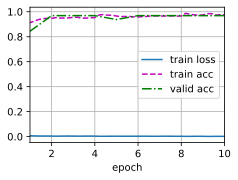

In [115]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 0.01, 1e-4
lr_period, lr_decay = 10, 0.1
net=get_net34(devices[0])
net # net应该属于一个分类器或处理器 CNN为深度学习工具
#net.hybridize()
train(net,train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,lr_decay)

loss 0.002, train acc 0.971, valid acc 0.875
331.1 examples/sec on [device(type='cuda', index=0)]


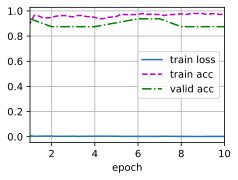

In [116]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 0.01, 1e-4
lr_period, lr_decay = 10, 0.1
net=get_net50(devices[0])
net # net应该属于一个分类器或处理器 CNN为深度学习工具
#net.hybridize()
train(net,train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,lr_decay)

loss 0.002, train acc 0.982, valid acc 0.969
146.5 examples/sec on [device(type='cuda', index=0)]


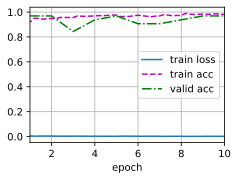

In [117]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 0.01, 1e-4
lr_period, lr_decay = 10, 0.1
net=get_net152(devices[0])
net # net应该属于一个分类器或处理器 CNN为深度学习工具
#net.hybridize()
train(net,train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,lr_decay)

In [ ]:
#valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)

"""Compute the accuracy for a model on a dataset using a GPU."""
if isinstance(net, torch.nn.Module):
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device
# No. of correct predictions, no. of predictions
metric = d2l.Accumulator(2)
for X, y in valid_iter:
    if isinstance(X, list):
        # Required for BERT Fine-tuning (to be covered later)
        X = [x.to(device) for x in X]
    else:
        X = X.to(device)
    y = y.to(device)
    metric.add(d2l.accuracy(net(X), y), d2l.size(y))

In [ ]:
dir(valid_iter)

In [ ]:
valid_iter.dataset

In [288]:
##metric[0] / metric[1]

In [145]:
loss = nn.CrossEntropyLoss()

devices, num_epochs, lr, wd = device, 10, 0.0001, 1e-4

# resnet34
net34 = get_net34(devices)
optimizer34 = torch.optim.Adam(net34.parameters(), lr=lr, weight_decay=wd)
print('开始训练resnet34')
net34.load_state_dict(torch.load('bees.pth'))
#d2l.train(train_iter, valid_iter, net34, loss, optimizer34, device, num_epochs)
print('训练完成,混淆矩阵如下')
# 训练结束,绘制混淆矩阵
preds = []
y_list = []
for data, label in train_valid_iter:
    output = net34(data.to(device))
    arrays = output.cpu().detach().numpy()
    li = []
    for array in arrays:
        p1, p2 = array
        if p1 > p2:
            li.append(0)
        else:
            li.append(1)
    preds.extend(li)
    y_list.extend(list(label.cpu().detach().numpy()))
confusion_matrix34 = confusion_matrix(y_list, preds)
print('resnet34', confusion_matrix34)
print('*' * 50)


开始训练resnet34


FileNotFoundError: [Errno 2] No such file or directory: 'bees.pth'

In [146]:



# resnet50
net50 = get_net50(devices)
optimizer50 = torch.optim.Adam(net50.parameters(), lr=lr, weight_decay=wd)
print('开始训练resnet50')
net50.load_state_dict(torch.load('best_bees.pth'))
# d2l.train(train_iter, valid_ite
# r, net50, loss, optimizer50, device, num_epochs)
print('训练完成,混淆矩阵如下')
# 训练结束,绘制混淆矩阵
preds = []
y_list = []
for data, label in train_valid_iter:
    output = net50(data.to(device))
    arrays = output.cpu().detach().numpy()
    li = []
    for array in arrays:
        p1, p2 = array
        if p1 > p2:
            li.append(0)
        else:
            li.append(1)
    preds.extend(li)
    y_list.extend(list(label.cpu().detach().numpy()))
confusion_matrix50 = confusion_matrix(y_list, preds)
print('resnet50', confusion_matrix50)
print('*' * 50)
# resnet152
net152 = get_net152(devices)
optimizer152 = torch.optim.Adam(net152.parameters(), lr=lr, weight_decay=wd)
print('开始训练resnet152')
d2l.train(train_iter, valid_iter, net152, loss, optimizer152, device, num_epochs)
print('训练完成,混淆矩阵如下')
# 训练结束,绘制混淆矩阵
preds = []
y_list = []
for data, label in train_valid_iter:
    output = net152(data.to(device))
    arrays = output.cpu().detach().numpy()
    li = []
    for array in arrays:
        p1, p2 = array
        if p1 > p2:
            li.append(0)
        else:
            li.append(1)
    preds.extend(li)
    y_list.extend(list(label.cpu().detach().numpy()))
confusion_matrix152 = confusion_matrix(y_list, preds)
print('resnet152', confusion_matrix152)
print('*' * 50)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\huawei matebook D15/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:19<00:00, 5.37MB/s]


开始训练resnet50


FileNotFoundError: [Errno 2] No such file or directory: 'best_bees.pth'